In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
from nipype.interfaces.nipy import SpaceTimeRealigner, ComputeMask
from nipype.interfaces.fsl import BET, MeanImage, ApplyMask, SwapDimensions, MELODIC
from nipype.interfaces.afni import SkullStrip, Automask, MaskTool
from nipype.algorithms.rapidart import ArtifactDetect
import seaborn as sns
from nipype.interfaces.ants import N4BiasFieldCorrection, Registration, ApplyTransforms
from pca_utils import pca_denoising
from denoise import nilearn_denoise, motion_regressors
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
#from nighres.registration import apply_coordinate_mappings, generate_coordinate_mapping

in_dir = '/home/julia/projects/lc/20181006_165517_JH_LC_rsfMRI_03_1_1_nifti/JHLCrsfMRI/'
out_dir = '/home/julia/projects/lc/JH_LC_rsfMRI_03_analysis/'
struct_file = in_dir +  'JHLCrsfMRI_20/JHLCrsfMRI_20.nii.gz'
struct_data = nb.load(struct_file).get_data()
struct_affine = nb.load(struct_file).affine
struct_header = nb.load(struct_file).header
#atlas_file = '/home/julia/projects/allen_brain/P56_Atlas_different.nii'
method_file = in_dir + 'JHLCrsfMRI_23/JHLCrsfMRI_23_method.npy'
par_file = in_dir +'JHLCrsfMRI_23/JHLCrsfMRI_23_visu_pars.npy'
func_file =  in_dir + 'JHLCrsfMRI_23/JHLCrsfMRI_23.nii.gz'
func_data = nb.load(func_file).get_data()
func_affine = nb.load(func_file).affine
func_header = nb.load(func_file).header
method = np.load(method_file)[()]
pars = np.load(par_file)[()]
TR = pars['VisuAcqRepetitionTime']

In [4]:
in_dir = '/home/julia/projects/lc/20181007_142810_JH_LC_rsfMRI_05_1_1_nifti/JHLCrsfMRI05/'
out_dir = '/home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/'
# struct_file = in_dir +  'JHLCrsfMRI_20/JHLCrsfMRI_20.nii.gz'
# struct_data = nb.load(struct_file).get_data()
# struct_affine = nb.load(struct_file).affine
# struct_header = nb.load(struct_file).header
#atlas_file = '/home/julia/projects/allen_brain/P56_Atlas_different.nii'
method_file = in_dir + 'JHLCrsfMRI05_16/JHLCrsfMRI05_16_method.npy'
par_file = in_dir +'JHLCrsfMRI05_16/JHLCrsfMRI05_16_visu_pars.npy'
func_file =  in_dir + 'JHLCrsfMRI05_16/JHLCrsfMRI05_16.nii.gz'
func_data = nb.load(func_file).get_data()
func_affine = nb.load(func_file).affine
func_header = nb.load(func_file).header
method = np.load(method_file)[()]
pars = np.load(par_file)[()]
TR = pars['VisuAcqRepetitionTime']

### Remove initial volumes

In [22]:
vol_to_remove = 10

In [23]:
mean_ts_before = np.average(np.average(np.average(func_data, axis=0), axis=0),axis=0)
mean_ts_after = np.average(np.average(np.average(func_data[:,:,:,vol_to_remove:], axis=0), axis=0),axis=0)

In [24]:
func_steady = nb.Nifti1Image(func_data[:,:,:,vol_to_remove:], func_affine, func_header)
nb.save(func_steady, out_dir+'func_steady.nii.gz')

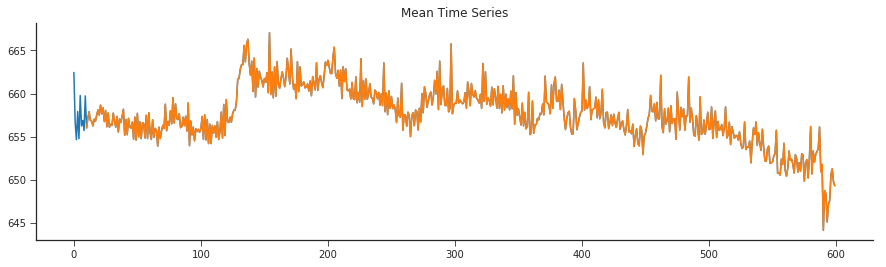

In [25]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,4))
plt.plot(mean_ts_before)
plt.plot(np.linspace(vol_to_remove, func_data.shape[3]-1, func_data.shape[3]-vol_to_remove), mean_ts_after)
plt.title("Mean Time Series")
sns.despine()

### Remove thermal noise

In [26]:
mp_data, mp_sigmas, mp_components = pca_denoising(nb.load(out_dir+'func_steady.nii.gz').get_data())
nb.save(nb.Nifti1Image(mp_data, func_affine, func_header), out_dir+'func_mp_data.nii.gz')
nb.save(nb.Nifti1Image(mp_sigmas, func_affine, func_header), out_dir+'func_mp_sigmas.nii.gz')
nb.save(nb.Nifti1Image(mp_components, func_affine, func_header), out_dir+'func_mp_components.nii.gz')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


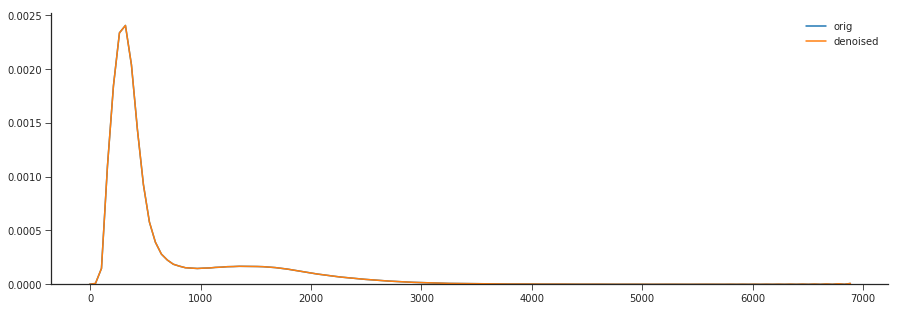

In [27]:
fig=plt.figure(figsize=(15,5))
sns.kdeplot(nb.load(out_dir+'func_mp_data.nii.gz').get_data().flatten(), label='orig')
sns.kdeplot(func_data[:,:,:,vol_to_remove:].flatten(), label='denoised')
plt.legend()
sns.despine()

In [28]:
mean1 = MeanImage(in_file=out_dir+'func_mp_data.nii.gz', out_file=out_dir+'func_mean_mp.nii.gz')
mean1.run()

### Motion correction

In [29]:
moco = SpaceTimeRealigner(in_file=out_dir+'func_mp_data.nii.gz')
res = moco.run()
func_moco = nb.load(res.outputs.out_file)
nb.save(func_moco, out_dir+'func_moco.nii.gz')
par_file = np.loadtxt(res.outputs.par_file)
np.savetxt(out_dir + 'func_moco_pars.txt', par_file)

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [30]:
mean2 = MeanImage(in_file=out_dir+'func_moco.nii.gz', out_file=out_dir+'func_mean_moco.nii.gz')
mean2.run()

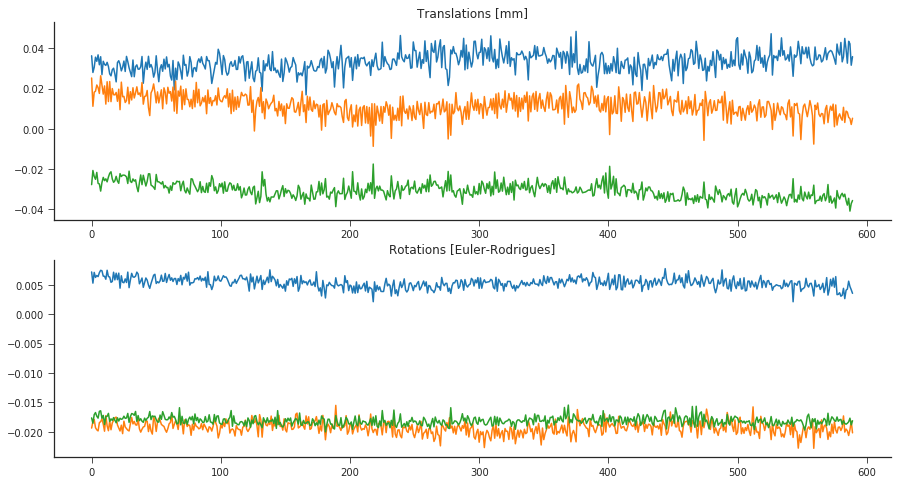

In [31]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
for i in [0,1,2]:
    plt.plot(par_file[:,i])
    plt.title("Translations [mm]")
fig.add_subplot(2,1,2)
for i in [3,4,5]:
    plt.plot(par_file[:,i])
    plt.title("Rotations [Euler-Rodrigues]")
sns.despine()

### Bias field correction and masking 

In [5]:
n4_func = N4BiasFieldCorrection(input_image=out_dir+'func_mean_moco.nii.gz', dimension=3,
                                   n_iterations=[150,100,50,30], convergence_threshold=1e-11,
                                   bspline_fitting_distance = 10, bspline_order = 4,
                                   shrink_factor = 2,
                                   output_image= out_dir + 'func_mean_corrected.nii.gz')
n4_func.cmdline

'N4BiasFieldCorrection --bspline-fitting [ 10, 4 ] -d 3 --input-image /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_mean_moco.nii.gz --convergence [ 150x100x50x30, 1e-11 ] --output /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_mean_corrected.nii.gz --shrink-factor 2'

In [33]:
func_mask = Automask(in_file=out_dir+'func_mean_corrected.nii.gz', out_file=out_dir+'func_mask.nii.gz',
                     brain_file=out_dir+'func_mean_masked.nii.gz', 
                     args='-peels 3', dilate=1, outputtype='NIFTI_GZ')
func_mask.run()

181021-15:49:13,487 interface INFO:
	 stderr 2018-10-21T15:49:13.487776:++ 3dAutomask: AFNI version=Debian-16.2.07~dfsg.1-5~nd16.04+1 (Jun 12 2017) [64-bit]
181021-15:49:13,488 interface INFO:
	 stderr 2018-10-21T15:49:13.487776:++ Authored by: Emperor Zhark
181021-15:49:13,493 interface INFO:
	 stderr 2018-10-21T15:49:13.493604:++ Loading dataset /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_mean_corrected.nii.gz
181021-15:49:13,503 interface INFO:
	 stderr 2018-10-21T15:49:13.503851:++ Forming automask
181021-15:49:13,509 interface INFO:
	 stderr 2018-10-21T15:49:13.509526: + Fixed clip level = 425.558441
181021-15:49:13,533 interface INFO:
	 stderr 2018-10-21T15:49:13.533122: + Used gradual clip level = 403.997406 .. 447.994385
181021-15:49:13,534 interface INFO:
	 stderr 2018-10-21T15:49:13.534256: + Number voxels above clip level = 75043
181021-15:49:13,539 interface INFO:
	 stderr 2018-10-21T15:49:13.534256: + Clustering voxels ...
181021-15:49:13,541 interface INFO:
	 st

### Coregistration functional to structural

In [18]:
coreg_lin = Registration(fixed_image = out_dir + 'struct/struct_weighted_avg_masked.nii.gz',
                         moving_image = out_dir + 'func_mean_masked.nii.gz',
                         output_warped_image = out_dir + 'func2struct_mean_lin.nii.gz',
                         output_transform_prefix = out_dir + 'func2struct_lin_',
                         dimension = 3,
                         transforms = ['Rigid'], 
                         metric = ['MI'], 
                         transform_parameters = [(0.1,)],
                         metric_weight = [1],
                         radius_or_number_of_bins = [32],
                         sampling_percentage = [0.33],
                         sampling_strategy = ['Regular'],
                         convergence_threshold = [1.e-11],
                         convergence_window_size = [10],
                         smoothing_sigmas = [[0]],
                         sigma_units = ['vox'],
                         shrink_factors = [[1]],
                         use_estimate_learning_rate_once = [False],
                         use_histogram_matching = [False],
                         number_of_iterations = [[300]],
                         collapse_output_transforms = True,
                         winsorize_lower_quantile = 0.05,
                         winsorize_upper_quantile = 0.95,
                         args = '--float',
                         num_threads = 3,
                         initial_moving_transform_com = True,
                         )
coreg_lin.run()

In [62]:
dil_mask = MaskTool(in_file=out_dir + 'struct/struct_mask.nii.gz', outputtype = 'NIFTI_GZ',
                    out_file=out_dir + 'struct/struct_mask_dil1.nii.gz',
                    dilate_inputs='1')
dil_mask.run()

In [75]:
lin_func = nb.load(out_dir + 'func2struct_mean_lin.nii.gz').get_data()
lin_func_aff = nb.load(out_dir + 'func2struct_mean_lin.nii.gz').affine
lin_func_hdr = nb.load(out_dir + 'func2struct_mean_lin.nii.gz').header
maskdil = nb.load(out_dir + 'struct/struct_mask_dil1.nii.gz').get_data()

nb.save(nb.Nifti1Image(lin_func*maskdil, lin_func_aff, lin_func_hdr),
        out_dir + 'func2struct_mean_lin_masked.nii.gz')

In [79]:
coreg_nonlin = Registration(fixed_image = out_dir + 'struct/struct_weighted_avg_masked.nii.gz',
                             moving_image = out_dir + 'func2struct_mean_lin_masked.nii.gz',
                             output_warped_image = out_dir + 'func2struct_mean_nonlin.nii.gz',
                             output_transform_prefix = out_dir + 'func2struct_nonlin_',
                             dimension = 3,
                             transforms = ['SyN'], 
                             metric = ['CC'], 
                             args = '--float',
                             transform_parameters = [(0.1, 3.0, 0)],
                             metric_weight = [1],
                             radius_or_number_of_bins = [4],
                             sampling_percentage = [None],
                             sampling_strategy = [None],
                             convergence_threshold = [1.e-6],
                             convergence_window_size = [10],
                             smoothing_sigmas = [[0,0]],
                             sigma_units = ['vox'],
                             shrink_factors = [[2,1]],
                             use_estimate_learning_rate_once = [False],
                             use_histogram_matching = [True],
                             number_of_iterations = [[50,10]],
                             collapse_output_transforms = True,
                             winsorize_lower_quantile = 0.05,
                             winsorize_upper_quantile = 0.95,
                             num_threads = 3,)
coreg_nonlin.run()

### Nuissance regression

In [37]:
artefact=ArtifactDetect(realigned_files=out_dir+'func_moco.nii.gz', mask_file=out_dir+'func_mask.nii.gz', 
                        realignment_parameters=out_dir+'func_moco_pars.txt' ,
                        save_plot=True, use_norm=True, parameter_source='NiPy',
                        mask_type='file', bound_by_brainmask=True, norm_threshold=0.04, zintensity_threshold=2,
                        use_differences=[True,False])
arts = artefact.run()

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:547: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julia/workspace/conda/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/julia/workspace/conda/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julia

In [38]:
norms=np.genfromtxt(arts.outputs.norm_files)
outliers=np.genfromtxt(arts.outputs.outlier_files)
intensity=np.genfromtxt(arts.outputs.intensity_files)

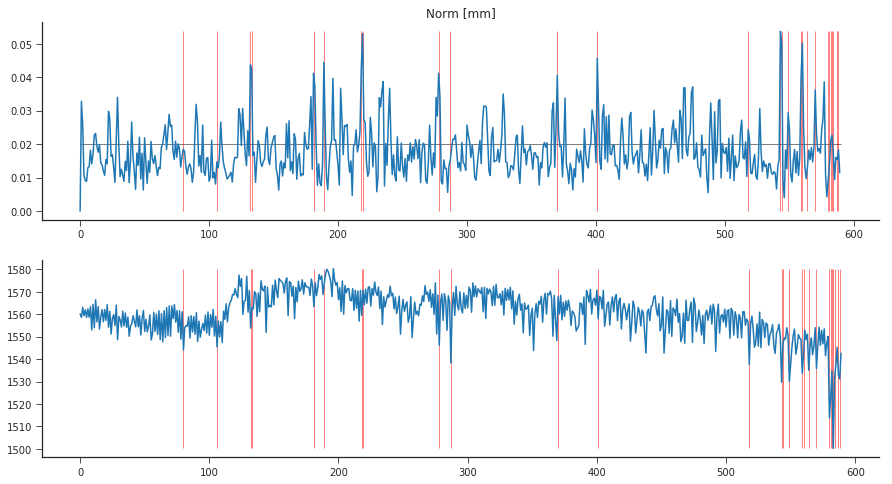

In [39]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
plt.plot(norms)
plt.hlines(0.02, 0, norms.shape[0], linewidth=0.5)
plt.vlines(outliers, norms.min(), norms.max(), linewidth=0.5, color='red')
plt.title("Norm [mm]")
fig.add_subplot(2,1,2)
plt.plot(intensity)
plt.vlines(outliers, intensity.min(), intensity.max(), linewidth=0.5, color='red')
sns.despine()

In [40]:
# create outlier regressors
outlier_file = arts.outputs.outlier_files
confound_len = norms.shape[0]
outlier_regressor = np.empty((confound_len,1))
try:
    outlier_val = np.genfromtxt(outlier_file)
except IOError:
    outlier_val = np.empty((0))
for index in np.atleast_1d(outlier_val):
    outlier_vector = np.zeros((confound_len, 1))
    outlier_vector[int(index)] = 1
    outlier_regressor = np.hstack((outlier_regressor, outlier_vector))
outlier_regressor = outlier_regressor[:,1::]

In [41]:
# calculate motion regressors
motreg_file = motion_regressors(out_dir+'func_moco_pars.txt', order=1, derivatives=1)
motion_regressor=np.genfromtxt(motreg_file[0])

In [42]:
confounds=np.hstack((outlier_regressor, motion_regressor))

In [43]:
brain_masker = NiftiMasker(mask_img=out_dir+'func_mask.nii.gz', standardize=True, detrend=True, 
                           low_pass=0.17, high_pass=0.01, t_r=3, smoothing_fwhm=0.02)
filtered_data = brain_masker.fit_transform(out_dir+'func_moco.nii.gz', confounds=confounds)
filtered_img = brain_masker.inverse_transform(filtered_data)
filtered_img.to_filename(out_dir+'func_filtered.nii.gz')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/nilearn/signal.py:175: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to nyquist frequency). It has been lowered to 0.17 (nyquist frequency).
  'frequency).' % (btype, nyq))


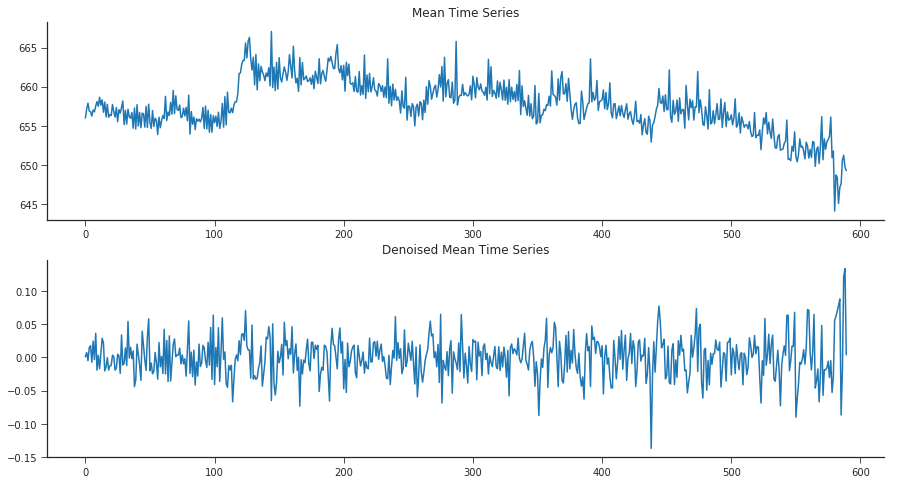

In [44]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
plt.plot(mean_ts_after)
plt.title("Mean Time Series")
fig.add_subplot(2,1,2)
plt.plot(np.average(filtered_data, axis=1))
plt.title("Denoised Mean Time Series")
sns.despine()

### ICA

In [45]:
ica= MELODIC(in_files=out_dir+'func_filtered.nii.gz',  mask=out_dir+'func_mask.nii.gz', 
             bg_image=out_dir+'func_mean_masked.nii.gz', out_dir=out_dir+'ica/',
             no_bet=True, bg_threshold=1, tr_sec=3, report=True)
ica.run()

In [46]:
! fsl_regfilt -i /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_filtered.nii.gz -d /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/ica/melodic_mix -f "1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,38,39,40" -o /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_denoised.nii.gz

### Bring LC mask in functional space
make LC mask in FSL, apply mipav transform in mipav

In [17]:
s=nb.load(out_dir+'struct/struct_avg_corrected.nii.gz')
m=nb.load(out_dir+'struct/lc_mask2struct.nii.gz')
nb.save(nb.Nifti1Image(m.get_data(), s.affine, s.header), out_dir+'struct/lc_mask2struct_fixed.nii.gz')

In [18]:
lc2func=ApplyTransforms(input_image=out_dir+'struct/lc_mask2struct_fixed.nii.gz',#'struct/lc_mask2struct.nii.gz', 
                        reference_image=out_dir+'func_mean_masked.nii.gz',
                        output_image=out_dir+'lc_mask2func.nii.gz',
                        transforms=[out_dir+'func2struct_lin_0GenericAffine.mat', 
                                    out_dir+'func2struct_nonlin_0InverseWarp.nii.gz'], 
                        invert_transform_flags=[True, False], 
                        dimension=3, interpolation='NearestNeighbor')
lc2func.run()

### Connectivity

In [47]:
conn_masker = NiftiMasker(mask_img=out_dir+'func_mask.nii.gz',smoothing_fwhm=0.2)
conn_ts = conn_masker.fit_transform(out_dir+'func_denoised.nii.gz')

In [48]:
seed_masker = NiftiMasker(mask_img=out_dir+'motor_mask.nii.gz',smoothing_fwhm=0.2)
seed_ts = seed_masker.fit_transform(out_dir+'func_denoised.nii.gz')
avg_seed_ts = np.average(seed_ts, axis=1)

In [49]:
seed_based_correlations = np.dot(conn_ts.T, avg_seed_ts) / avg_seed_ts.shape[0]
seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)

In [50]:
seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations_fisher_z.T)
seed_based_correlation_img.to_filename(out_dir+'motor_connectivity.nii.gz')